In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/dataset.zip" "dataset.zip"

In [ ]:
!unzip -q dataset.zip
!unzip -q dataset/dualclass.zip
!unzip -q dataset/test2classes.zip

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

class SeparableConvolution(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.dwc = nn.Sequential(
            nn.Conv2d(input_channel, input_channel, kernel_size, stride, padding, dilation, groups=input_channel, bias=bias),
            nn.Conv2d(input_channel, output_channel, 1, 1, 0, 1, 1, bias=bias)
        )
    
    def forward(self, X):
        return self.dwc(X)

class Block(nn.Module):
    def __init__(self, input_channel, out_channel, reps, strides=1, relu=True, grow_first=True):
        super().__init__()
        if out_channel != input_channel or strides!=1:
            self.skipConnections = nn.Sequential(
                nn.Conv2d(input_channel, out_channel, 1, stride=strides, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        else:
            self.skipConnections = None
        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = input_channel
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConvolution(input_channel, out_channel, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_channel))
            filters = out_channel
        
        for _ in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConvolution(filters, filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConvolution(input_channel, out_channel, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_channel))

        if not relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3, strides, 1))

        self.rep = nn.Sequential(*rep)

    def forward(self, input):
        X = self.rep(input)

        if self.skipConnections:
            skip = self.skipConnections(input)
        else:
            skip = input
        
        X += skip
        return X

class Xception(nn.Module):
    def __init__(self, input_channel, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.relu = nn.ReLU(inplace=True)

        self.initBlock = nn.Sequential(
            nn.Conv2d(input_channel, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size = 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.block1=Block(64,128,2,2,relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,relu=True,grow_first=False)

        self.convolution3 = SeparableConvolution(1024,1536,3,1,1)
        self.batchnorm3 = nn.BatchNorm2d(1536)

        #do relu here
        self.convolution4 = SeparableConvolution(1536,2048,3,1,1)
        self.batchnorm4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, self.n_classes)

        #weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.initBlock(x)
        x = self.block1(x)
        
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.convolution3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        
        x = self.convolution4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        
        data, target = data.to(device), target.to(device)  
        
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    


def validate(model, device, val_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in val_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(val_loader.dataset), acc.avg))
    return loss.avg,acc.avg
##define test function

def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('dualclass/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, val_files, train_classes, val_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['NORM' 'TUM']


In [ ]:
with open('test2classes/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
test_files=files
test_classes = classes
print(len(test_files))
print(len(test_classes))

['NORM' 'TUM']
7200
7200


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 5 # We use a small batch size here for training
batch_size_test = 10 #
batch_size_val = 10

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('dualclass/', train_files, train_classes, 
                         transforms=image_transform)
val_dataset = Hist('dualclass/', val_files, val_classes, 
                         transforms=image_transform)
test_dataset = Hist('test2classes/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=batch_size_val, 
                                           shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: NORM


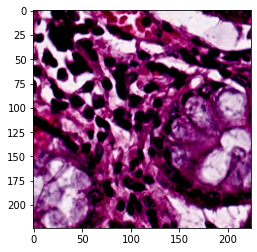

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
drive.flush_and_unmount()
!rm -rf /content/drive

In [ ]:
import os.path
from os import path
import torch.nn.functional as F
import torch.optim as optim

num_epoch = 30
accuracy_test=[]

for i in range(5):
  print('Experiment: ', i+1)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Xception(input_channel=3, n_classes=2).to(device)
  learning_rate = 0.0005
  weight_decay = 0.001
  for param in model.parameters():
    param.requires_grad = True
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)

  acc=0
  for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=validate(model, device, val_loader)
    if acc<acct:
      if path.exists("Xception2SGD.pth"):
        os.remove("Xception2SGD.pth")
      torch.save(model.state_dict(), 'Xception2SGD.pth')
      acc=acct

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Xception(input_channel=3, n_classes=2).to(device)
  model.load_state_dict(torch.load('Xception2SGD.pth', map_location=device))
  model=model.to(device)
  
  l,a=test(model, device, test_loader)
  accuracy_test.append(a)
print(accuracy_test)

Experiment:  1
1


<ipython-input-6-7ceae6cba87a>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3627

Test: Average loss: 0.1395, Accuracy: 8605/9096 (94.60%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2439

Test: Average loss: 0.0846, Accuracy: 8840/9096 (97.19%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1748

Test: Average loss: 0.0937, Accuracy: 8809/9096 (96.84%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1327

Test: Average loss: 0.1335, Accuracy: 8618/9096 (94.74%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1120

Test: Average loss: 0.0844, Accuracy: 8856/9096 (97.36%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0982

Test: Average loss: 0.0722, Accuracy: 8887/9096 (97.70%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0855

Test: Average loss: 0.0613, Accuracy: 8915/9096 (98.01%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0740

Test: Average loss: 0.0954, Accuracy: 8790/9096 (96.64%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0674

Test: Average loss: 0.1306, Accuracy: 8728/9096 (95.95%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0609

Test: Average loss: 0.0809, Accuracy: 8844/9096 (97.23%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0580

Test: Average loss: 0.0684, Accuracy: 8867/9096 (97.48%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0543

Test: Average loss: 0.0541, Accuracy: 8924/9096 (98.11%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0481

Test: Average loss: 0.0685, Accuracy: 8872/9096 (97.54%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0462

Test: Average loss: 0.0548, Accuracy: 8949/9096 (98.38%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0428

Test: Average loss: 0.0741, Accuracy: 8865/9096 (97.46%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0362

Test: Average loss: 1.1836, Accuracy: 8058/9096 (88.59%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0397

Test: Average loss: 0.0437, Accuracy: 8957/9096 (98.47%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0312

Test: Average loss: 0.0476, Accuracy: 8962/9096 (98.53%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0294

Test: Average loss: 0.0398, Accuracy: 8973/9096 (98.65%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0291

Test: Average loss: 0.0427, Accuracy: 8974/9096 (98.66%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0254

Test: Average loss: 0.0433, Accuracy: 8970/9096 (98.61%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0262

Test: Average loss: 0.1778, Accuracy: 8505/9096 (93.50%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0900

Test: Average loss: 0.0429, Accuracy: 8976/9096 (98.68%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0443

Test: Average loss: 0.1301, Accuracy: 8646/9096 (95.05%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0338

Test: Average loss: 0.0556, Accuracy: 8914/9096 (98.00%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0245

Test: Average loss: 0.0541, Accuracy: 8927/9096 (98.14%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0265

Test: Average loss: 0.0368, Accuracy: 8993/9096 (98.87%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0177

Test: Average loss: 0.0711, Accuracy: 8873/9096 (97.55%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0174

Test: Average loss: 0.0423, Accuracy: 8980/9096 (98.72%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0202

Test: Average loss: 0.0377, Accuracy: 8986/9096 (98.79%)

Test: Average loss: 0.0193, Accuracy: 7157/7200 (99.40%)

Experiment:  2
1


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3422

Test: Average loss: 0.1317, Accuracy: 8646/9096 (95.05%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2320

Test: Average loss: 0.0924, Accuracy: 8824/9096 (97.01%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1669

Test: Average loss: 0.1251, Accuracy: 8758/9096 (96.28%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1330

Test: Average loss: 0.2671, Accuracy: 8057/9096 (88.58%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1032

Test: Average loss: 0.0619, Accuracy: 8920/9096 (98.07%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0948

Test: Average loss: 0.0642, Accuracy: 8914/9096 (98.00%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0843

Test: Average loss: 0.0541, Accuracy: 8940/9096 (98.28%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0741

Test: Average loss: 0.0568, Accuracy: 8928/9096 (98.15%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0686

Test: Average loss: 0.0479, Accuracy: 8934/9096 (98.22%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0598

Test: Average loss: 0.4495, Accuracy: 8074/9096 (88.76%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0519

Test: Average loss: 0.1263, Accuracy: 8707/9096 (95.72%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0627

Test: Average loss: 0.0445, Accuracy: 8956/9096 (98.46%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0438

Test: Average loss: 0.0884, Accuracy: 8834/9096 (97.12%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0381

Test: Average loss: 0.0354, Accuracy: 8982/9096 (98.75%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0385

Test: Average loss: 0.0356, Accuracy: 8985/9096 (98.78%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0370

Test: Average loss: 0.0924, Accuracy: 8834/9096 (97.12%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0301

Test: Average loss: 0.0619, Accuracy: 8914/9096 (98.00%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0279

Test: Average loss: 0.0361, Accuracy: 8989/9096 (98.82%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0296

Test: Average loss: 0.0483, Accuracy: 8935/9096 (98.23%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0231

Test: Average loss: 0.0458, Accuracy: 8951/9096 (98.41%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0210

Test: Average loss: 0.0492, Accuracy: 8954/9096 (98.44%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0223

Test: Average loss: 0.0403, Accuracy: 8975/9096 (98.67%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0204

Test: Average loss: 0.0741, Accuracy: 8878/9096 (97.60%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0167

Test: Average loss: 0.0727, Accuracy: 8879/9096 (97.61%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0144

Test: Average loss: 0.0493, Accuracy: 8962/9096 (98.53%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0136

Test: Average loss: 0.0354, Accuracy: 9006/9096 (99.01%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0171

Test: Average loss: 0.0406, Accuracy: 8981/9096 (98.74%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0186

Test: Average loss: 0.0349, Accuracy: 9000/9096 (98.94%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0130

Test: Average loss: 0.0482, Accuracy: 8974/9096 (98.66%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0095

Test: Average loss: 0.0477, Accuracy: 8961/9096 (98.52%)

Test: Average loss: 0.0256, Accuracy: 7148/7200 (99.28%)

Experiment:  3
1


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3579

Test: Average loss: 0.1269, Accuracy: 8703/9096 (95.68%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2346

Test: Average loss: 0.0879, Accuracy: 8799/9096 (96.73%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1795

Test: Average loss: 0.1344, Accuracy: 8592/9096 (94.46%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1434

Test: Average loss: 0.1265, Accuracy: 8735/9096 (96.03%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1132

Test: Average loss: 0.1447, Accuracy: 8711/9096 (95.77%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0972

Test: Average loss: 0.1104, Accuracy: 8859/9096 (97.39%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0853

Test: Average loss: 0.0594, Accuracy: 8916/9096 (98.02%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0713

Test: Average loss: 0.1409, Accuracy: 8758/9096 (96.28%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0640

Test: Average loss: 0.0458, Accuracy: 8965/9096 (98.56%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0637

Test: Average loss: 0.0483, Accuracy: 8951/9096 (98.41%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0582

Test: Average loss: 0.1824, Accuracy: 8514/9096 (93.60%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0538

Test: Average loss: 0.1120, Accuracy: 8787/9096 (96.60%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0548

Test: Average loss: 0.0417, Accuracy: 8976/9096 (98.68%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0520

Test: Average loss: 0.0396, Accuracy: 8968/9096 (98.59%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0418

Test: Average loss: 0.0461, Accuracy: 8952/9096 (98.42%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0398

Test: Average loss: 0.0641, Accuracy: 8906/9096 (97.91%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0345

Test: Average loss: 0.0450, Accuracy: 8964/9096 (98.55%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0349

Test: Average loss: 0.0347, Accuracy: 8998/9096 (98.92%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0270

Test: Average loss: 0.0620, Accuracy: 8896/9096 (97.80%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0266

Test: Average loss: 0.0502, Accuracy: 8941/9096 (98.30%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0275

Test: Average loss: 0.0466, Accuracy: 8950/9096 (98.39%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0240

Test: Average loss: 0.0779, Accuracy: 8889/9096 (97.72%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0228

Test: Average loss: 0.0542, Accuracy: 8958/9096 (98.48%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0266

Test: Average loss: 0.0497, Accuracy: 8957/9096 (98.47%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0207

Test: Average loss: 0.1733, Accuracy: 8603/9096 (94.58%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0181

Test: Average loss: 0.0437, Accuracy: 8976/9096 (98.68%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0225

Test: Average loss: 0.1780, Accuracy: 8816/9096 (96.92%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0163

Test: Average loss: 0.0386, Accuracy: 8993/9096 (98.87%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0118

Test: Average loss: 0.0377, Accuracy: 8996/9096 (98.90%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0153

Test: Average loss: 0.0666, Accuracy: 8920/9096 (98.07%)

Test: Average loss: 0.0256, Accuracy: 7136/7200 (99.11%)

Experiment:  4
1


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3612

Test: Average loss: 0.1681, Accuracy: 8584/9096 (94.37%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2343

Test: Average loss: 0.3230, Accuracy: 8109/9096 (89.15%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1750

Test: Average loss: 0.3197, Accuracy: 7924/9096 (87.12%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1426

Test: Average loss: 0.1130, Accuracy: 8730/9096 (95.98%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1133

Test: Average loss: 0.0722, Accuracy: 8902/9096 (97.87%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0949

Test: Average loss: 0.1030, Accuracy: 8755/9096 (96.25%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0871

Test: Average loss: 0.0737, Accuracy: 8863/9096 (97.44%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0718

Test: Average loss: 0.1178, Accuracy: 8805/9096 (96.80%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0723

Test: Average loss: 0.0594, Accuracy: 8931/9096 (98.19%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0643

Test: Average loss: 1.1018, Accuracy: 7475/9096 (82.18%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0554

Test: Average loss: 0.0550, Accuracy: 8911/9096 (97.97%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0566

Test: Average loss: 0.0558, Accuracy: 8938/9096 (98.26%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0471

Test: Average loss: 0.0431, Accuracy: 8988/9096 (98.81%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0501

Test: Average loss: 0.0847, Accuracy: 8802/9096 (96.77%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0446

Test: Average loss: 0.0398, Accuracy: 8988/9096 (98.81%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0361

Test: Average loss: 0.0411, Accuracy: 8977/9096 (98.69%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0450

Test: Average loss: 0.0538, Accuracy: 8914/9096 (98.00%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0333

Test: Average loss: 0.0446, Accuracy: 8964/9096 (98.55%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0278

Test: Average loss: 0.0587, Accuracy: 8931/9096 (98.19%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0222

Test: Average loss: 0.0566, Accuracy: 8919/9096 (98.05%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0233

Test: Average loss: 0.0358, Accuracy: 8993/9096 (98.87%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0302

Test: Average loss: 0.0643, Accuracy: 8921/9096 (98.08%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0401

Test: Average loss: 0.3204, Accuracy: 8299/9096 (91.24%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0237

Test: Average loss: 0.0611, Accuracy: 8900/9096 (97.85%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0223

Test: Average loss: 0.0384, Accuracy: 8991/9096 (98.85%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0203

Test: Average loss: 0.0452, Accuracy: 8955/9096 (98.45%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0137

Test: Average loss: 0.0661, Accuracy: 8930/9096 (98.18%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0226

Test: Average loss: 0.0530, Accuracy: 8950/9096 (98.39%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0155

Test: Average loss: 0.0427, Accuracy: 8969/9096 (98.60%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0133

Test: Average loss: 0.0855, Accuracy: 8876/9096 (97.58%)

Test: Average loss: 0.0195, Accuracy: 7150/7200 (99.31%)

Experiment:  5
1


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3527

Test: Average loss: 0.1548, Accuracy: 8549/9096 (93.99%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2378

Test: Average loss: 0.1048, Accuracy: 8809/9096 (96.84%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1737

Test: Average loss: 0.0814, Accuracy: 8863/9096 (97.44%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1306

Test: Average loss: 0.0597, Accuracy: 8911/9096 (97.97%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1133

Test: Average loss: 0.1015, Accuracy: 8778/9096 (96.50%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0895

Test: Average loss: 0.0513, Accuracy: 8949/9096 (98.38%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0891

Test: Average loss: 0.0748, Accuracy: 8862/9096 (97.43%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0767

Test: Average loss: 0.0731, Accuracy: 8857/9096 (97.37%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0729

Test: Average loss: 0.0672, Accuracy: 8907/9096 (97.92%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0611

Test: Average loss: 0.1503, Accuracy: 8694/9096 (95.58%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0554

Test: Average loss: 0.0463, Accuracy: 8970/9096 (98.61%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0511

Test: Average loss: 0.0528, Accuracy: 8945/9096 (98.34%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0421

Test: Average loss: 0.0441, Accuracy: 8988/9096 (98.81%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0414

Test: Average loss: 0.1336, Accuracy: 8669/9096 (95.31%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0393

Test: Average loss: 0.0634, Accuracy: 8941/9096 (98.30%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0440

Test: Average loss: 0.0382, Accuracy: 8979/9096 (98.71%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0361

Test: Average loss: 0.0430, Accuracy: 8966/9096 (98.57%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0302

Test: Average loss: 0.0489, Accuracy: 8963/9096 (98.54%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0282

Test: Average loss: 0.0378, Accuracy: 8987/9096 (98.80%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0255

Test: Average loss: 0.0627, Accuracy: 8900/9096 (97.85%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0242

Test: Average loss: 0.0427, Accuracy: 8974/9096 (98.66%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0202

Test: Average loss: 0.0712, Accuracy: 8855/9096 (97.35%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0158

Test: Average loss: 0.0464, Accuracy: 8978/9096 (98.70%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0226

Test: Average loss: 0.0528, Accuracy: 8926/9096 (98.13%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0160

Test: Average loss: 0.0521, Accuracy: 8950/9096 (98.39%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0208

Test: Average loss: 0.0605, Accuracy: 8923/9096 (98.10%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0213

Test: Average loss: 0.0517, Accuracy: 8965/9096 (98.56%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0125

Test: Average loss: 0.0560, Accuracy: 8937/9096 (98.25%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0585

Test: Average loss: 0.0502, Accuracy: 8953/9096 (98.43%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0277

Test: Average loss: 0.0762, Accuracy: 8856/9096 (97.36%)

Test: Average loss: 0.0327, Accuracy: 7140/7200 (99.17%)

[99.40277777777777, 99.27777777777777, 99.11111111111111, 99.30555555555556, 99.16666666666667]


In [1]:
import numpy as np
acc=np.array([99.40277777777777, 99.27777777777777, 99.11111111111111, 99.30555555555556, 99.16666666666667])
print(np.mean(acc))
print(np.std(acc))

99.25277777777777
0.10333930687632012


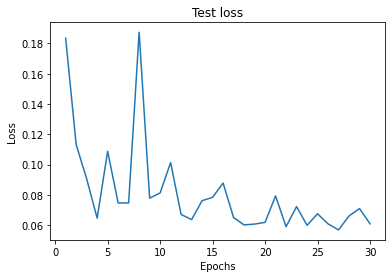

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,test_loss)
plt.title('Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

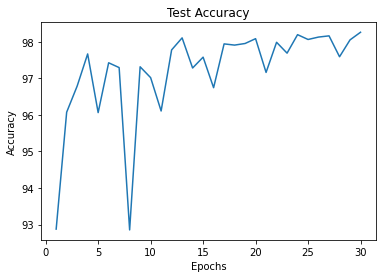

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,accuracy_test)
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()